In [57]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, pipeline
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import matplotlib.pyplot as plt



### Setup the dataset

In [33]:
df = pd.read_csv('../data.csv')

In [34]:
# Drop useless columns
df.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'], axis=1, inplace=True)

In [35]:
# Drop rows with NaN values
df.dropna(inplace=True)

<Axes: xlabel='Score'>

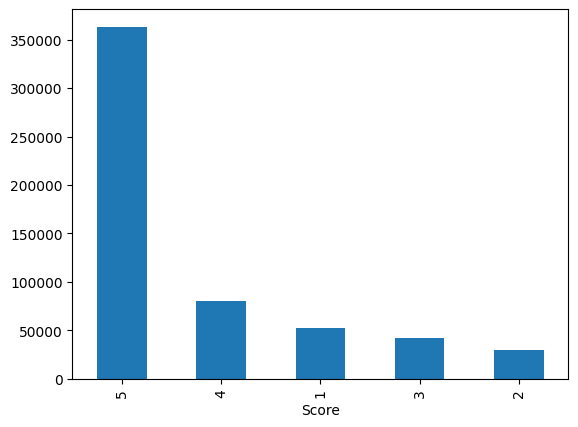

In [36]:
# Plot the distribution of the ratings
df['Score'].value_counts().plot(kind='bar')

<Axes: xlabel='Score'>

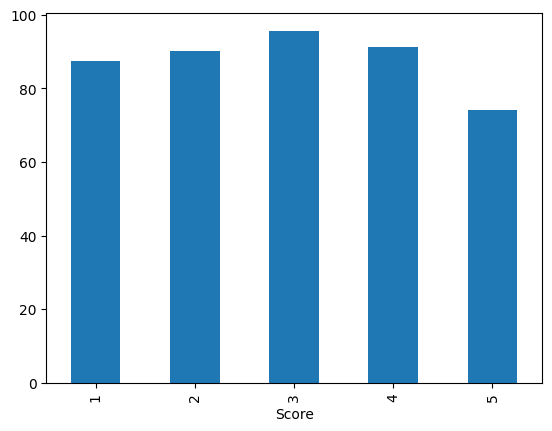

In [37]:
# Plot mean length of reviews per score

df['length'] = df['Text'].apply(lambda x: len(x.split()))
df.groupby('Score')['length'].mean().plot(kind='bar')

<Axes: xlabel='Score'>

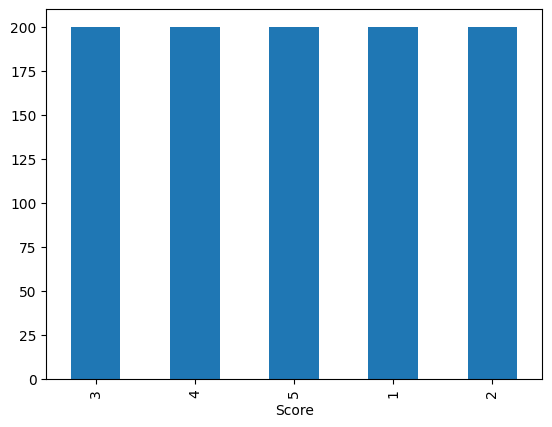

In [38]:
# Egalize the number of reviews per score and shuffle the dataframe

df = df.groupby('Score').apply(lambda x: x.sample(n=200, random_state=42)).reset_index(drop=True)

df = df.sample(frac=1, random_state=42)


# Plot the distribution of the ratings

df['Score'].value_counts().plot(kind='bar')


### Process the dataset

In [39]:
# Preprocess data

tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

X = dict(tokenizer(
    text=df['Text'].to_list(),
    return_tensors='np',
    padding=True,
    truncation=True,
))

y = np.array(df['Score'].apply(lambda x: x-1))

In [40]:
# Split data into train and test sets

test_size = 0.2

X_train = {key: value[:-int(len(value)*test_size)] for key, value in X.items()}
X_test = {key: value[-int(len(value)*test_size):] for key, value in X.items()}
y_train = y[:-int(len(y)*test_size)]
y_test = y[-int(len(y)*test_size):]


### Define and train the model

In [41]:
model = TFAutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model.compile(optimizer=Adam(3e-5), metrics=['accuracy'])

Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [42]:
history = model.fit(
    X_train,
    y_train,
    epochs=1,
    validation_split=0.2,
    verbose=1
)

20/20 [==============================] - 2917s 146s/step - loss: 1.1001 - val_loss: 1.0558


In [43]:
# Save model

model.save_pretrained('albert_model')

In [44]:
# Evaluate model with metrics

print(model.evaluate(X_test, y_test))


7/7 [==============================] - 143s 19s/step - loss: 0.9996
0.999559223651886


### Use the saved model to make predictions

In [54]:
# Create a pipeline

model = TFAutoModelForSequenceClassification.from_pretrained('albert_model')
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, return_all_scores=True)

Some layers from the model checkpoint at albert_model were not used when initializing TFBertForSequenceClassification: ['dropout_75']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at albert_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/trans

<Axes: xlabel='label'>

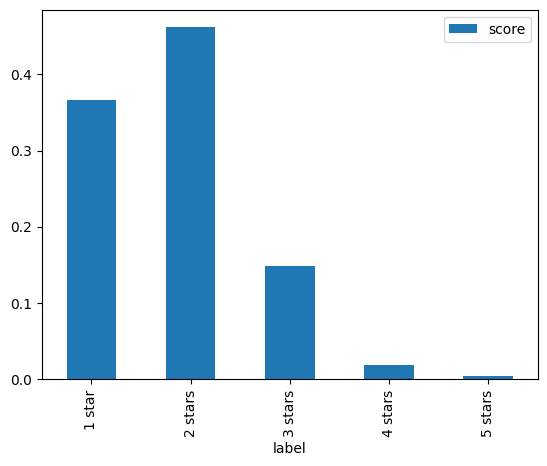

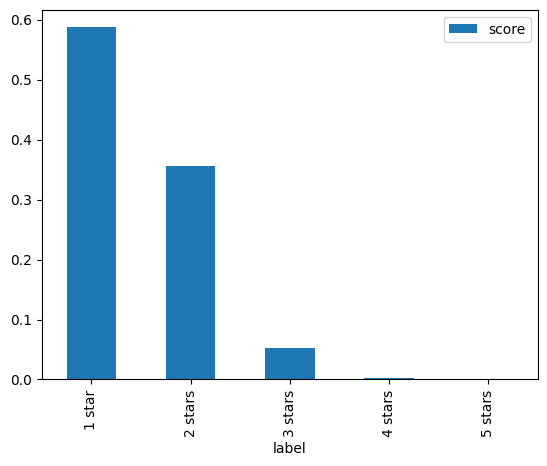

In [76]:
# Plot the result of the the pipeline

good_text = pd.DataFrame(classifier("e produit s'est déterioré au bout d'une semaine")[0])
bad_text = pd.DataFrame(classifier("This product is bad. I would not recommend it to anyone.")[0])

good_text.plot(kind='bar', x='label', y='score')
bad_text.plot(kind='bar', x='label', y='score')
